In [ ]:
import os
import pandas as pd
from dotenv import load_dotenv
from lib.adjust_stage1_data import adjust_stage1_data
from lib.run_stage1_regression import run_stage1_regression
from lib.generate_stage1_results_table import generate_stage1_results_table
import matplotlib.pyplot as plot
import numpy as np

load_dotenv()
workdir = os.getenv('WORKDIR')
print(workdir)

if not workdir:
    raise ValueError("Environment variable 'WORKDIR' not set or not found in .env file.")
print(f"Working Directory: {workdir}")


In [2]:


os.chdir(workdir)

all_shocks_file = "data/allShocks.xlsx"
regression_data_file = "data/regressionData.xlsx"

stage1_data_df = pd.read_excel("data/stage1Data.xlsx")
all_shocks_monthly_df = pd.read_excel(all_shocks_file, sheet_name="Monthly UK")
all_shocks_quarterly_df = pd.read_excel(all_shocks_file, sheet_name="Quarterly UK")
regression_data_monthly_df = pd.read_excel(regression_data_file, sheet_name="Monthly UK")
regression_data_quarterly_df = pd.read_excel(regression_data_file, sheet_name="Quarterly UK")

adjusted_stage1_data = adjust_stage1_data(stage1_data_df)

shocks, summary = run_stage1_regression(adjusted_stage1_data)

table2 = generate_stage1_results_table(summary)

with open("results/table-2.tex", "w") as file:
    file.write(table2)




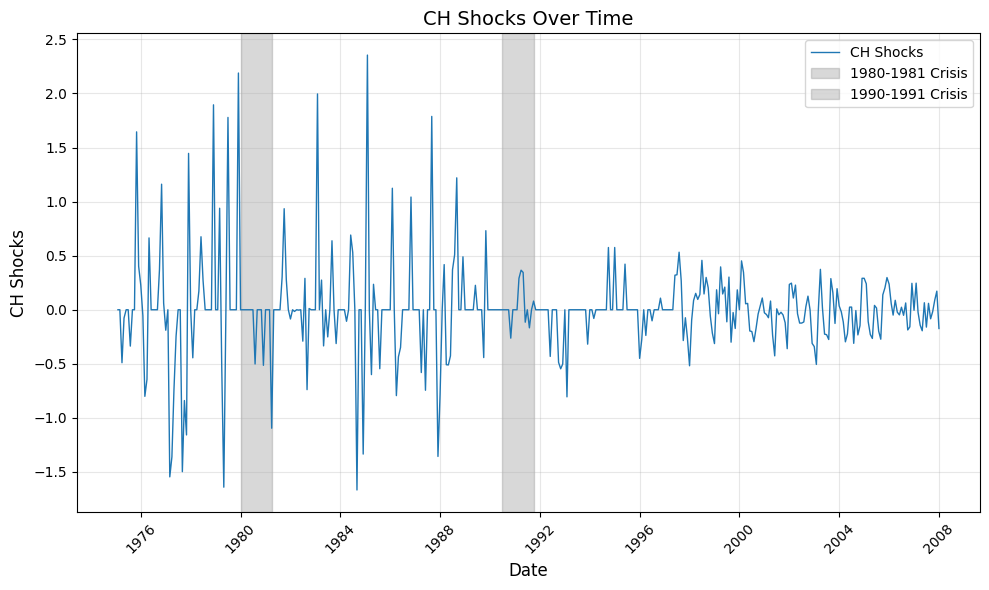

In [3]:
plot.figure(figsize=(10, 6))
plot.plot(all_shocks_monthly_df["Date"], all_shocks_monthly_df["CH shocks"], label="CH Shocks", linewidth=1)

# Shade Crisis Time Intervals
plot.axvspan(pd.Timestamp('1980-01-01'), pd.Timestamp('1981-03-31'), color='gray', alpha=0.3, label="1980-1981 Crisis")
plot.axvspan(pd.Timestamp('1990-07-01'), pd.Timestamp('1991-09-30'), color='gray', alpha=0.3, label="1990-1991 Crisis")

plot.title('CH Shocks Over Time', fontsize=14)
plot.xlabel('Date', fontsize=12)
plot.ylabel('CH Shocks', fontsize=12)
plot.xticks(rotation=45)
plot.grid(alpha=0.3)
plot.legend()
plot.tight_layout()
plot.savefig("results/Figure-1.png", dpi=300, bbox_inches='tight')
plot.show()

In [4]:
from lib.process_regression_data import process_regression_data

monthly_data, quarterly_data = process_regression_data(regression_data_monthly_df, regression_data_quarterly_df)

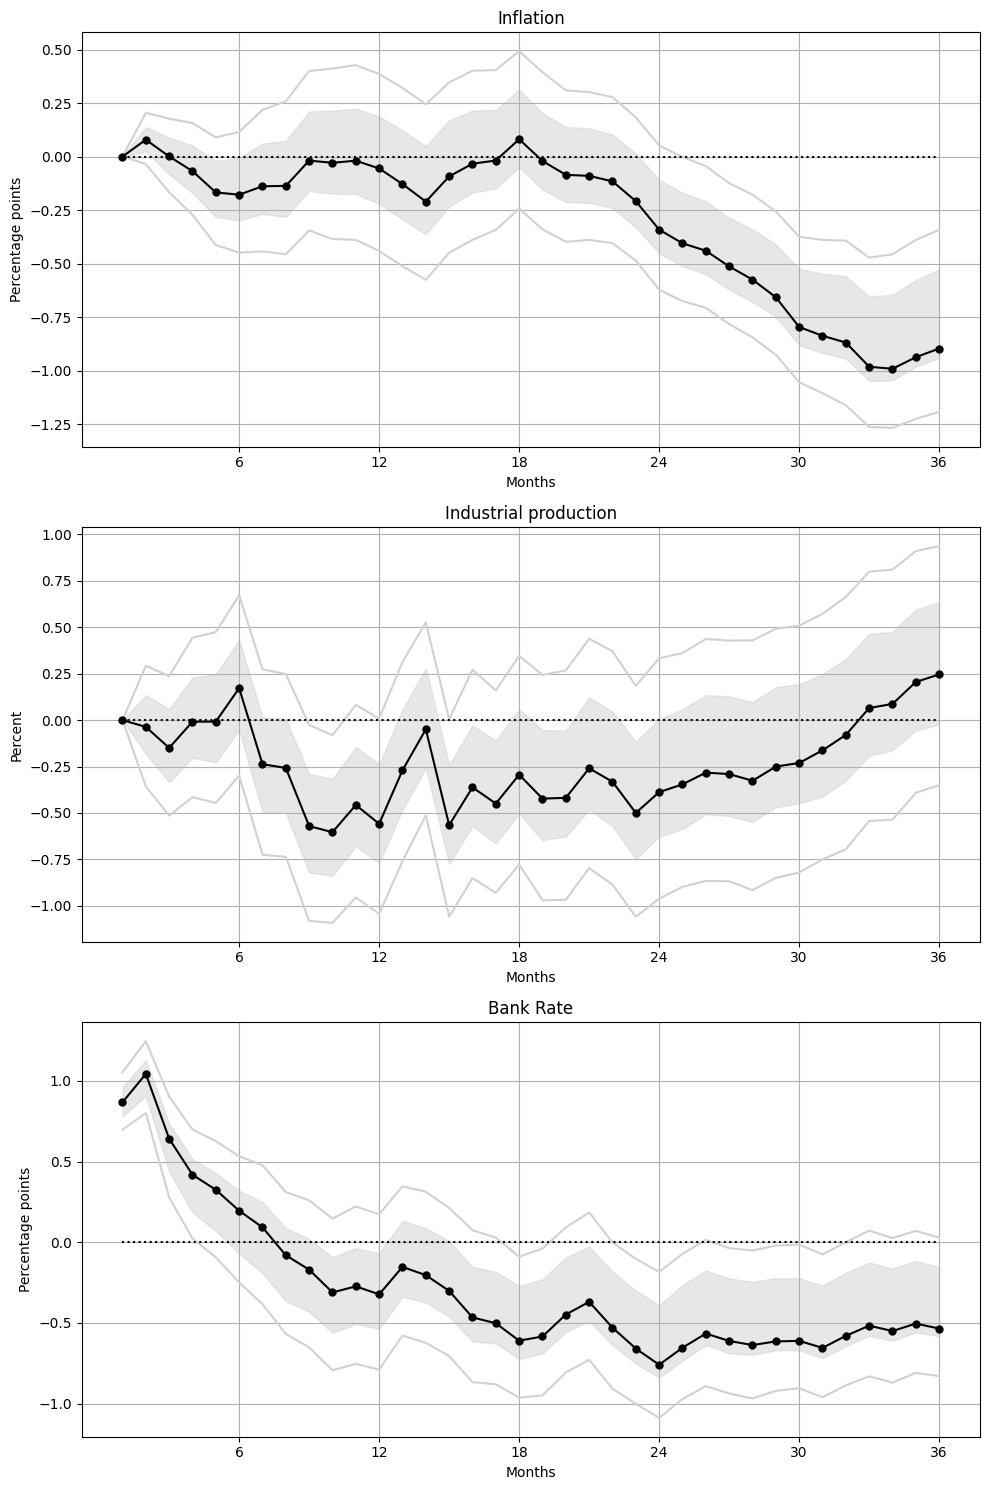

In [5]:
from lib.var_regression import var_regression
from lib.impulse_response_function import impulse_response_function
from lib.bootstrap import bootstrap

baseShocks = all_shocks_monthly_df['CH shocks']
cumShocks = np.cumsum(baseShocks)

# BASELINE REGRESSION
data = np.column_stack([
    monthly_data['LogIndProd'],
    monthly_data['Inf'],
    monthly_data['LogComPrice']
])

# Assuming cumShocks is already loaded or computed
data = np.column_stack([data, cumShocks])

# Set up VAR parameters
params = {
    'r': data.shape[0],
    'nvar': data.shape[1],
    'nreps': 2000,  # Number of bootstrap repetitions
    'shockPosition': data.shape[1],
    'irfhorizon': 36,
    'P': 24  # lags
}

# Perform baseline estimation
coeffs = var_regression(data, params)

irf = impulse_response_function(coeffs, params)

irf = bootstrap(data, coeffs, params, irf)

# Add policy rate to the VAR
data = np.column_stack([data, monthly_data['BR']])

params['r'] = data.shape[0]
params['shockPosition'] = 4
params['nvar'] = 5

# Perform baseline estimation with bank rate
coeffs_br = var_regression(data, params)
irf_br = impulse_response_function(coeffs_br, params)
irf_br = bootstrap(data, coeffs_br, params, irf_br)

# PLOTTING
number_of_x_ticks = params['irfhorizon'] // 6
zeroline = np.zeros(params['irfhorizon'])
x = np.arange(1, params['irfhorizon'] + 1)

fig, axs = plot.subplots(3, 1, figsize=(10, 15))

# Inflation
axs[0].fill_between(x, irf['lower68'][1, :], irf['upper68'][1, :], color=[0.82, 0.82, 0.82], alpha=0.5)
axs[0].plot(x, irf['lower95'][1, :], color=[0.82, 0.82, 0.82])
axs[0].plot(x, irf['upper95'][1, :], color=[0.82, 0.82, 0.82])
axs[0].plot(x, irf['point'][1, :], '-ok', markersize=5)
axs[0].plot(x, zeroline, ':k')
axs[0].grid(True)
axs[0].set_xticks(np.linspace(6, params['irfhorizon'], number_of_x_ticks))
axs[0].set_title('Inflation')
axs[0].set_xlabel('Months')
axs[0].set_ylabel('Percentage points')

# Industrial production
axs[1].fill_between(x, irf['lower68'][0, :], irf['upper68'][0, :], color=[0.82, 0.82, 0.82], alpha=0.5)
axs[1].plot(x, irf['lower95'][0, :], color=[0.82, 0.82, 0.82])
axs[1].plot(x, irf['upper95'][0, :], color=[0.82, 0.82, 0.82])
axs[1].plot(x, irf['point'][0, :], '-ok', markersize=5)
axs[1].plot(x, zeroline, ':k')
axs[1].grid(True)
axs[1].set_xticks(np.linspace(6, params['irfhorizon'], number_of_x_ticks))
axs[1].set_title('Industrial production')
axs[1].set_xlabel('Months')
axs[1].set_ylabel('Percent')


# Bank Rate
axs[2].fill_between(x, irf_br['lower68'][4, :], irf_br['upper68'][4, :], color=[0.82, 0.82, 0.82], alpha=0.5)
axs[2].plot(x, irf_br['lower95'][4, :], color=[0.82, 0.82, 0.82])
axs[2].plot(x, irf_br['upper95'][4, :], color=[0.82, 0.82, 0.82])
axs[2].plot(x, irf_br['point'][4, :], '-ok', markersize=5)
axs[2].plot(x, zeroline, ':k')
axs[2].grid(True)
axs[2].set_xticks(np.linspace(6, params['irfhorizon'], number_of_x_ticks))
axs[2].set_title('Bank Rate')
axs[2].set_xlabel('Months')
axs[2].set_ylabel('Percentage points')

plot.tight_layout()

plot.savefig("results/Figure-2.png", dpi=300, bbox_inches='tight')
plot.show()

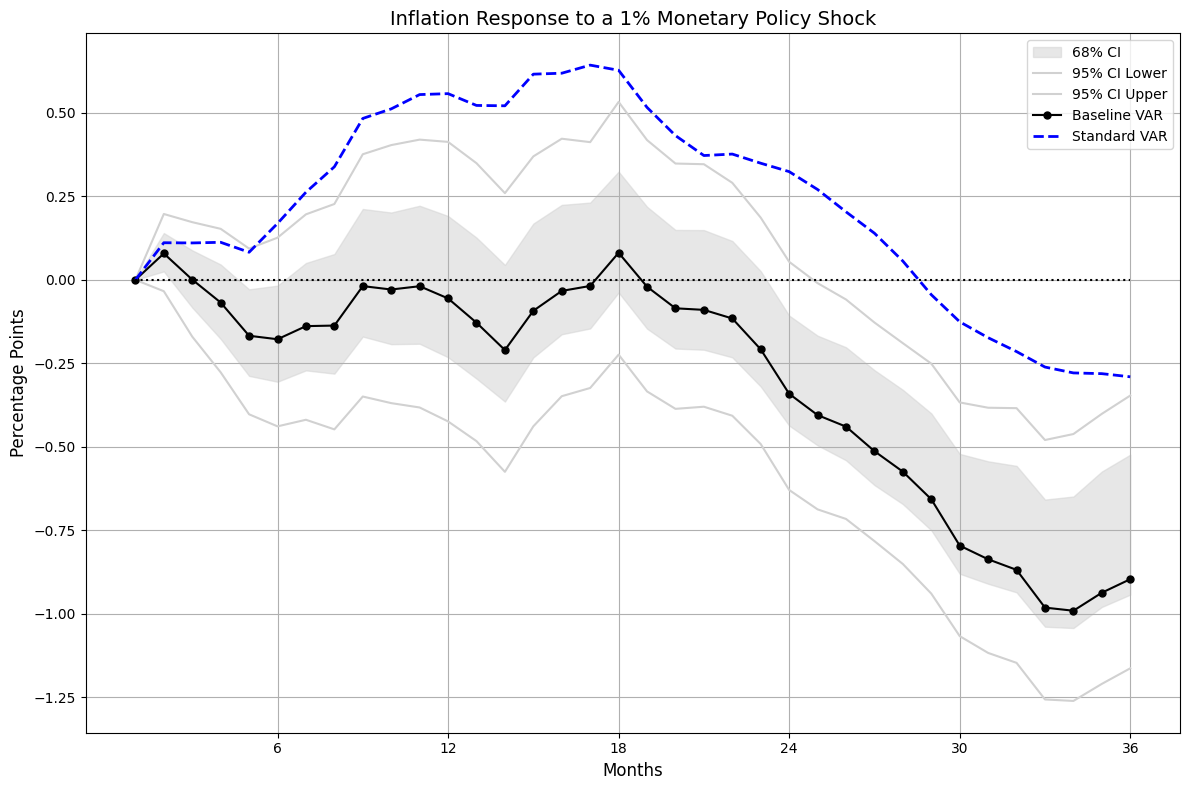

In [6]:

# Baseline VAR Data
data_for_baseline = np.column_stack([
    monthly_data['LogIndProd'],
    monthly_data['Inf'],
    monthly_data['LogComPrice'],
    cumShocks
])

# Standard VAR Data
data_for_standard = np.column_stack([
    monthly_data['LogIndProd'],
    monthly_data['Inf'],
    monthly_data['LogComPrice'],
    monthly_data['BR']
])

params['r'] = data_for_baseline.shape[0]
params['nvar'] = data_for_baseline.shape[1]
params['shockPosition'] = data_for_baseline.shape[1]

coeffs_for_baseline = var_regression(data_for_baseline, params)
irf_for_baseline = impulse_response_function(coeffs_for_baseline, params)
irf_for_baseline = bootstrap(data_for_baseline, coeffs_for_baseline, params, irf_for_baseline)

coeffs_for_standard = var_regression(data_for_standard, params)
irf_for_standard = impulse_response_function(coeffs_for_standard, params)

# Plotting Figure 4
number_of_x_ticks = params['irfhorizon'] // 6
zeroline = np.zeros(params['irfhorizon'])
x = np.arange(1, params['irfhorizon'] + 1)

plot.figure(figsize=(12, 8))

plot.fill_between(x, irf_for_baseline['lower68'][1, :], irf_for_baseline['upper68'][1, :], color=[0.82, 0.82, 0.82], alpha=0.5, label='68% CI')
plot.plot(x, irf_for_baseline['lower95'][1, :], color=[0.82, 0.82, 0.82], label='95% CI Lower')
plot.plot(x, irf_for_baseline['upper95'][1, :], color=[0.82, 0.82, 0.82], label='95% CI Upper')

plot.plot(x, irf_for_baseline['point'][1, :], '-ok', markersize=5, label='Baseline VAR')

plot.plot(x, irf_for_standard['point'][1, :], 'b--', linewidth=2, label='Standard VAR')

plot.plot(x, zeroline, ':k')

plot.title('Inflation Response to a 1% Monetary Policy Shock', fontsize=14)
plot.xlabel('Months', fontsize=12)
plot.ylabel('Percentage Points', fontsize=12)
plot.grid(True)
plot.legend(loc='upper right')
plot.xticks(np.linspace(6, params['irfhorizon'], number_of_x_ticks))

plot.tight_layout()

plot.savefig("results/Figure-4.png", dpi=300, bbox_inches='tight')
plot.show()


In [ ]:
from lib.local_projection import local_projection

params = {
    "irfhorizon": 48,
    "P": 4,
    "Q": 48,
    "Start": 36,
    "Contemp": 0,
    "allControls": 1
}

data = {
    "Shocks": np.column_stack([baseShocks])
}

data['end'] = monthly_data[['LogIndProd', 'Inf', 'LogComPrice']].to_numpy()

irf= local_projection(data, params)

data["end"] = np.column_stack([
    monthly_data["BR"],
    monthly_data["LogIndProd"],
    monthly_data["Inf"],
    monthly_data["LogComPrice"]
])

params["Contemp"] = 1
params["allControls"] = 0
irf_br = local_projection(data, params)


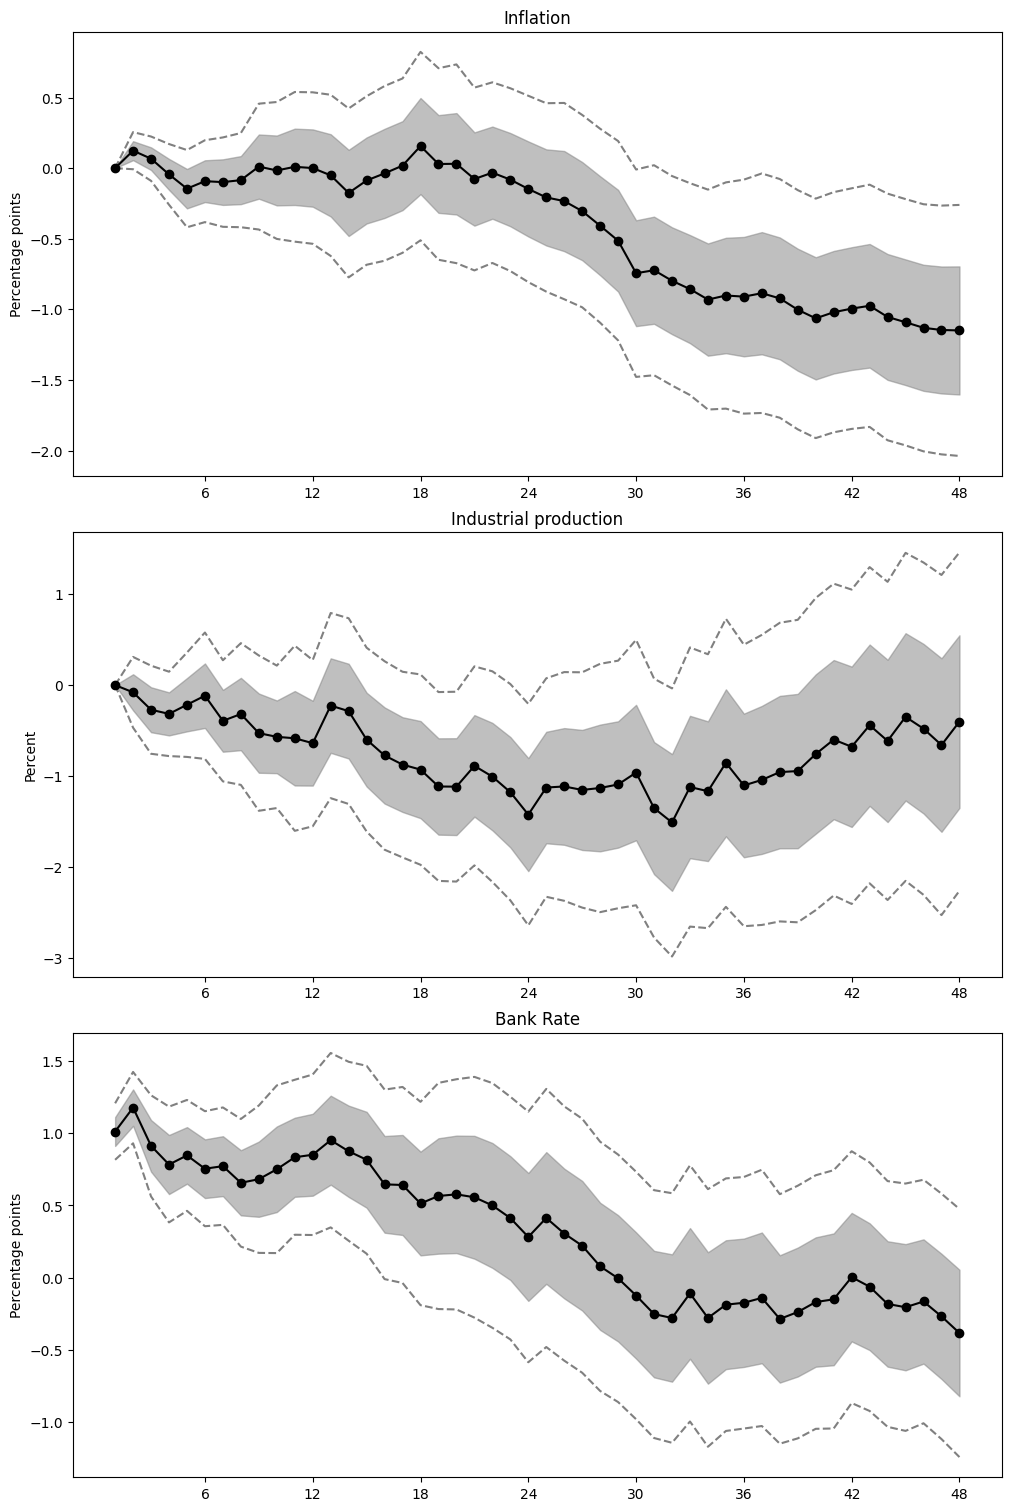

In [8]:

# Plotting
x_ticks = params['irfhorizon'] // 6
zeroline = np.zeros(params['irfhorizon'])
x = np.arange(1, params['irfhorizon'] + 1)

fig, axes = plot.subplots(3, 1, figsize=(10, 15), constrained_layout=True)


# Inflation
axes[0].fill_between(x, irf['lower68'][:, 1], irf['upper68'][:, 1], color='grey', alpha=0.5)
axes[0].plot(x, irf['lower95'][:, 1], color='grey', linestyle='--')
axes[0].plot(x, irf['upper95'][:, 1], color='grey', linestyle='--')
axes[0].plot(x, irf['point'][:, 1], 'k-o')
axes[0].set_xticks(np.linspace(6, params['irfhorizon'], x_ticks))
axes[0].set_title('Inflation')
axes[0].set_ylabel('Percentage points')

# Industrial production
axes[1].fill_between(x, irf['lower68'][:, 0], irf['upper68'][:, 0], color='grey', alpha=0.5)
axes[1].plot(x, irf['lower95'][:, 0], color='grey', linestyle='--')
axes[1].plot(x, irf['upper95'][:, 0], color='grey', linestyle='--')
axes[1].plot(x, irf['point'][:, 0], 'k-o')
axes[1].set_xticks(np.linspace(6, params['irfhorizon'], x_ticks))
axes[1].set_title('Industrial production')
axes[1].set_ylabel('Percent')

# Bank Rate
axes[2].fill_between(x, irf_br['lower68'][:, 0], irf_br['upper68'][:, 0], color='grey', alpha=0.5)
axes[2].plot(x, irf_br['lower95'][:, 0], color='grey', linestyle='--')
axes[2].plot(x, irf_br['upper95'][:, 0], color='grey', linestyle='--')
axes[2].plot(x, irf_br['point'][:, 0], 'k-o')
axes[2].set_xticks(np.linspace(6, params['irfhorizon'], x_ticks))
axes[2].set_title('Bank Rate')
axes[2].set_ylabel('Percentage points')


plot.savefig("results/Figure-7.png", dpi=300, bbox_inches='tight')
plot.show()

In [ ]:
if (all_shocks_quarterly_df.index.name != "Date"):
  all_shocks_quarterly_df.set_index("Date", inplace=True)
from statsmodels.tsa.stattools import grangercausalitytests
from lib.generate_table_3 import generate_table_3

baseShocks = all_shocks_quarterly_df['CH shocks']
regression_data = {
    "industrialProduction": quarterly_data['IoP_diff'],
    "monthlyInflation": quarterly_data["RPIX12m"], # Good enough
    "unemploymentRate":quarterly_data["Unemp"],
    "moneyGrowthM0": quarterly_data["Money_Growth"], # Good
    "commodityPriceInflation": quarterly_data['CommodityPrice'],
    "changeInFTSE": quarterly_data['ChangeFTSE'],
    "monetary_shocks": baseShocks,
}

# Convert to DataFrame
df = pd.DataFrame(regression_data).dropna()
# Define variables to test causality
variables = [
    "industrialProduction",
    "monthlyInflation",
    "unemploymentRate",
    "moneyGrowthM0",
    "commodityPriceInflation",
    "changeInFTSE",
]

# # Function to perform Granger causality tests
def granger_test(df, dependent_var, independent_vars, max_lag):
    results = []
    for var in independent_vars:
        test_result = grangercausalitytests(
            df[[dependent_var, var]], max_lag
        )
        # Extract F-statistic and p-value for the max_lag
        f_stat = test_result[max_lag][0]["ssr_ftest"][0]
        p_value = test_result[max_lag][0]["ssr_ftest"][1]
        results.append((var, f_stat, p_value))
    return results

# # Perform tests for I = 3 and I = 6 lags
results_3_lags = granger_test(df, "monetary_shocks", variables, max_lag=3)
results_6_lags = granger_test(df, "monetary_shocks", variables, max_lag=6)

# # Create summary DataFrame
summary_3_lags = pd.DataFrame(results_3_lags, columns=["Variable", "F-statistics", "p-values"])
summary_6_lags = pd.DataFrame(results_6_lags, columns=["Variable", "F-statistics", "p-values"])

table3 = generate_table_3(summary_3_lags, summary_6_lags)

